In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train=pd.read_csv("/content/drive/MyDrive/CS 539 Final Project/Data Split/train_preprocessing.csv")
test=pd.read_csv("/content/drive/MyDrive/CS 539 Final Project/Data Split/test_preprocessing.csv")
valid=pd.read_csv("/content/drive/MyDrive/CS 539 Final Project/Data Split/valid_preprocessing.csv")
# fill null values
train['text'].fillna("", inplace = True)
test['text'].fillna("", inplace = True)
valid['text'].fillna("", inplace = True)
train

,id,date,flag,user,text,target
0,1982498874,Sun May 31 11:19:51 PDT 2009,NO_QUERY,Sun_Immaculate,miss cut grass cut grass burn smell smell burn...,0.0
1,2052542788,Sat Jun 06 01:05:28 PDT 2009,NO_QUERY,cookiemonster82,chang vote wont bat today co rain cricketsweep,1.0
2,2072011839,Sun Jun 07 20:15:00 PDT 2009,NO_QUERY,davidallentv,ty link boost even tho didnt copi whole link t...,1.0
3,2266222859,Sun Jun 21 08:07:29 PDT 2009,NO_QUERY,babyyg,whatt feeel,0.0
4,1973430757,Sat May 30 11:07:59 PDT 2009,NO_QUERY,aoitshirts,circl triangl,0.0
...,...,...,...,...,...,...
959995,1692515784,Sun May 03 20:09:50 PDT 2009,NO_QUERY,jgonzalez14,fleuri im get old im not hip anymor haha,0.0
959996,2056733151,Sat Jun 06 11:41:32 PDT 2009,NO_QUERY,cocovelvett,land figur ride back car,0.0
959997,1976861893,Sat May 30 19:20:24 PDT 2009,NO_QUERY,AutismIsARose,get off work return apartmentturn tv saw weath...,1.0
959998,2169479730,Sun Jun 14 14:34:20 PDT 2009,NO_QUERY,sheepeatingtaz,far much wine lose chunk day,0.0


In [3]:
# train test split
X_test=test['text']
y_test=test['target']

# train test split
X_train=train['text']
y_train=train['target']

# train test split
X_val=valid['text']
y_val=valid['target']

In [9]:
import pickle
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

with open('/content/drive/MyDrive/CS 539 Final Project/Ensemble/RNN/third/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [10]:
sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences, maxlen=max_len)

sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(sequences, maxlen=max_len)

sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(sequences, maxlen=max_len)
X_test

array([[   0,    0,    0, ...,   21,    3,   21],
       [   0,    0,    0, ...,    0, 2285,  222],
       [   0,    0,    0, ...,   18,  257,  286],
       ...,
       [   0,    0,    0, ...,    0,   61,  862],
       [   0,    0,    0, ...,    0,    0,    8],
       [   0,    0,    0, ...,   19,   31,  133]], dtype=int32)

In [13]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Bidirectional, LSTM, Concatenate, 
                                     Dropout, Embedding, GRU, SimpleRNN,
                                     Input, Attention, GlobalMaxPool1D, Flatten)
from tensorflow.keras.optimizers import Adam
import os
from keras.callbacks import ModelCheckpoint
checkpoint_path = "/content/drive/MyDrive/CS 539 Final Project/Ensemble/Attention/adjusted/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)



input_size = 200
inputs = Input(shape=(input_size))
x = Embedding(max_words, 256,
                    input_length=input_size)(inputs)
x = Dropout(0.3)(x)
decoder = Dense(256, activation="relu")(x)
decoder = Dropout(0.3)(decoder)
att = Attention(128)([x, decoder])
att = Flatten()(att)
att = Dense(64, activation="relu")(att)
att = Dropout(0.3)(att)
predictions = Dense(1, activation='sigmoid')(att)

model2 = Model(inputs=inputs, outputs=predictions)

model2.compile(loss='binary_crossentropy',
              optimizer='Adam', metrics=['accuracy'])

model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 256)     1280000     ['input_2[0][0]']                
                                                                                                  
 dropout_3 (Dropout)            (None, 200, 256)     0           ['embedding_1[0][0]']            
                                                                                                  
 dense_3 (Dense)                (None, 200, 256)     65792       ['dropout_3[0][0]']              
                                                                                            

In [17]:
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, batch_size=16, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint])
# history = model2.fit(X_train, y_train, batch_size=16, validation_split=0.2, epochs=10, verbose=1)
# history = model.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/10
59998/60000 [============================>.] - ETA: 0s - loss: 0.4879 - accuracy: 0.7690
Epoch 1: val_accuracy improved from -inf to 0.77789, saving model to /content/drive/MyDrive/CS 539 Final Project/Ensemble/Attention/adjusted/cp.ckpt
60000/60000 [==============================] - 388s 6ms/step - loss: 0.4879 - accuracy: 0.7690 - val_loss: 0.4698 - val_accuracy: 0.7779
Epoch 2/10
59992/60000 [============================>.] - ETA: 0s - loss: 0.4762 - accuracy: 0.7762
Epoch 2: val_accuracy improved from 0.77789 to 0.77799, saving model to /content/drive/MyDrive/CS 539 Final Project/Ensemble/Attention/adjusted/cp.ckpt
60000/60000 [==============================] - 344s 6ms/step - loss: 0.4762 - accuracy: 0.7762 - val_loss: 0.4644 - val_accuracy: 0.7780
Epoch 3/10
59991/60000 [============================>.] - ETA: 0s - loss: 0.4728 - accuracy: 0.7781
Epoch 3: val_accuracy improved from 0.77799 to 0.78106, saving model to /content/drive/MyDrive/CS 539 Final Project/Ensemble/

In [23]:
import joblib
filename = "/content/drive/MyDrive/CS 539 Final Project/Ensemble/Attention/adjusted/att.joblib"
joblib.dump(model2, filename)

['/content/drive/MyDrive/CS 539 Final Project/Ensemble/Attention/adjusted/att.joblib']

In [22]:
model2.save("/content/drive/MyDrive/CS 539 Final Project/Ensemble/Attention/adjusted/att")

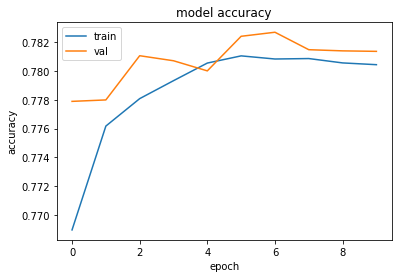

In [20]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

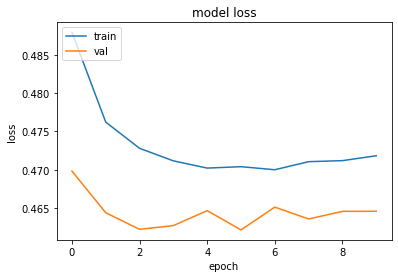

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 58s 6ms/step - loss: 0.4695 - accuracy: 0.7767


[0.4695484936237335, 0.7767093777656555]